In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

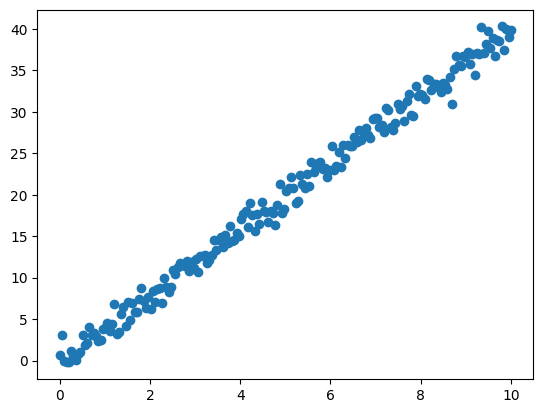

In [35]:
N=200
x=torch.linspace(0,10,N)
y=4*x+torch.randn(N)
plt.plot(x,y,'o')
plt.show()

In [37]:
N_train=int(0.8*N)
idx=torch.randperm(N)
x=x[idx]
y=y[idx]
x_train=x[:N_train]
y_train=y[:N_train]
x_test=x[N_train:]
y_test=y[N_train:]

# MLE

$$ L(y;x) = \underset{i=1}{\Pi^{N_{data}}} \mathcal{N}(y_i;\mu(x_i),\sigma^2)$$
$$\mu(x) = \sum_\alpha c_\alpha P^\alpha(x)$$
$$ \mathcal{L} = -\log L = C +  N_{data} \log{\sigma}^{-\frac12} + \sum_{i=1}^{N_{data}} \frac{(y_i - \mu_i)^2}{2 \sigma^2}  $$
Taking the variation of the loss $\mathcal{L}$ with respect to $c_\alpha$ and $\sigma$ gives an explicit formula for the minimal loss as a least squares problem.

$$\sum_{i=1}^{N_{data}} P^\alpha(x_i) P^\beta(x_i) c_\beta = \sum_{i=1}^{N_{data}} P^\alpha(x_i) y_i$$

First, construct the basis P = [1,x] evaluated on the data points

In [ ]:
Pbasis = torch.stack([torch.ones_like(x), x], dim=1)

Next, build up the normal equations matrix and RHS by performing a tensor contraction over the data. We can use einsum to do this easily.

In [ ]:
Nmatrix = torch.einsum('ij,ik->ij', Pbasis, Pbasis)
rhs = torch.einsum('ij,i->j', Pbasis, y_train)

Finally, we can use a direct solve to get the polynomial coefficients and plot the solution.

In [ ]:
coeffs = torch.solve(rhs, Nmatrix).solution
print(coeffs)

Taking the variation with respect to $\sigma$ we get the following expression for the variance (you might recognize this as the empirical variance).
$$\sigma^2 = \frac{\sum_i (y_i - \mu_i)^2}{N_{data}}$$

In [ ]:
variance = torch.mean((torch.einsum('ij,j->i', Pbasis, coeffs) - y_train)**2)

We can finally postprocess the solution with error bars to visualize the uncertainty.

In [ ]:
yfit = torch.einsum('ij,j->i', Pbasis, coeffs)
std_dev = torch.sqrt(variance)

plt.errorbar(x_train, y_train, yerr=std_dev, fmt='o', label='Data with error bars')
plt.plot(x_train, yfit, label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#Neural networks: harder to train, dead neurons, black-boxes

In [117]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression,self).__init__()
        self.linear=nn.Linear(1,1)
        self.activation=nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.fill_(0.01)
        self.linear.bias.data.fill_(0)

    def forward(self,x):
        x=self.linear(x)
        x=self.activation(x)
        return x

In [118]:
model=LinearRegression()
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

for epoch in range(100):
    inputs=x_train.unsqueeze(1)
    labels=y_train.unsqueeze(1)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1,100,loss.item()))

Epoch [1/100], Loss: 526.2596
Epoch [2/100], Loss: 457.4018
Epoch [3/100], Loss: 397.5764
Epoch [4/100], Loss: 345.5989
Epoch [5/100], Loss: 300.4398
Epoch [6/100], Loss: 261.2046
Epoch [7/100], Loss: 227.1164
Epoch [8/100], Loss: 197.4998
Epoch [9/100], Loss: 171.7683
Epoch [10/100], Loss: 149.4123
Epoch [11/100], Loss: 129.9889
Epoch [12/100], Loss: 113.1134
Epoch [13/100], Loss: 98.4517
Epoch [14/100], Loss: 85.7132
Epoch [15/100], Loss: 74.6458
Epoch [16/100], Loss: 65.0302
Epoch [17/100], Loss: 56.6760
Epoch [18/100], Loss: 49.4176
Epoch [19/100], Loss: 43.1114
Epoch [20/100], Loss: 37.6324
Epoch [21/100], Loss: 32.8721
Epoch [22/100], Loss: 28.7363
Epoch [23/100], Loss: 25.1429
Epoch [24/100], Loss: 22.0210
Epoch [25/100], Loss: 19.3085
Epoch [26/100], Loss: 16.9519
Epoch [27/100], Loss: 14.9044
Epoch [28/100], Loss: 13.1254
Epoch [29/100], Loss: 11.5798
Epoch [30/100], Loss: 10.2370
Epoch [31/100], Loss: 9.0702
Epoch [32/100], Loss: 8.0565
Epoch [33/100], Loss: 7.1758
Epoch [34/

In [119]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[3.9001]], requires_grad=True)
Parameter containing:
tensor([0.5510], requires_grad=True)


In [122]:
class LinearRegression2(nn.Module):
    def __init__(self):
        super(LinearRegression2,self).__init__()
        self.linear1=nn.Linear(1,10)
        self.linear2=nn.Linear(10,10)
        self.linear3=nn.Linear(10,10)
        self.linear4=nn.Linear(10,1)

        self.activation=nn.ReLU()
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)

    def forward(self,x):
        x=self.linear1(x)
        x=self.activation(x)
        x=self.linear2(x)
        x=self.activation(x)
        x=self.linear3(x)
        x=self.activation(x)
        x=self.linear4(x)
        x=self.activation(x)
        return x

In [124]:
model=LinearRegression2()
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

for epoch in range(100):
    inputs=x_train.unsqueeze(1)
    labels=y_train.unsqueeze(1)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1,100,loss.item()))

Epoch [1/100], Loss: 503.5899
Epoch [2/100], Loss: 453.4569
Epoch [3/100], Loss: 363.6775
Epoch [4/100], Loss: 193.2069
Epoch [5/100], Loss: 8.6709
Epoch [6/100], Loss: 8.9867
Epoch [7/100], Loss: 15.2199
Epoch [8/100], Loss: 13.4180
Epoch [9/100], Loss: 24.2504
Epoch [10/100], Loss: 17.1556
Epoch [11/100], Loss: 32.0394
Epoch [12/100], Loss: 18.7002
Epoch [13/100], Loss: 35.1846
Epoch [14/100], Loss: 18.8457
Epoch [15/100], Loss: 35.3277
Epoch [16/100], Loss: 18.6431
Epoch [17/100], Loss: 34.7380
Epoch [18/100], Loss: 18.3939
Epoch [19/100], Loss: 34.0642
Epoch [20/100], Loss: 18.1489
Epoch [21/100], Loss: 33.4137
Epoch [22/100], Loss: 17.9156
Epoch [23/100], Loss: 32.8002
Epoch [24/100], Loss: 17.6940
Epoch [25/100], Loss: 32.2227
Epoch [26/100], Loss: 17.4833
Epoch [27/100], Loss: 31.6781
Epoch [28/100], Loss: 17.2826
Epoch [29/100], Loss: 31.1631
Epoch [30/100], Loss: 17.0910
Epoch [31/100], Loss: 30.6751
Epoch [32/100], Loss: 16.9077
Epoch [33/100], Loss: 30.2114
Epoch [34/100], L